In [1]:
import pandas as pd
import numpy as np
import bs4
from bs4 import BeautifulSoup
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import sklearn
from sklearn import preprocessing, linear_model, model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import neighbors, tree, ensemble, naive_bayes, svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Perceptron

df=pd.read_csv('CarsDataFrame168.csv')

In [2]:
# before we are going to working on the data, cleaning and fixing, we will take a
#look on the information of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167898 entries, 0 to 167897
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Region        167898 non-null  object 
 1   Model         167897 non-null  object 
 2   Year          167103 non-null  float64
 3   Price         154014 non-null  object 
 4   Odometer      165542 non-null  float64
 5   Condition     98759 non-null   object 
 6   Fuel type     165853 non-null  object 
 7   Transmission  166942 non-null  object 
 8   Paint color   117132 non-null  object 
dtypes: float64(2), object(7)
memory usage: 11.5+ MB


In [3]:
# after we took a look at the information of the data set, we are going
# to working on each column and drop all the null values, and fill the missing information on the data 

#MODEL COLUMN
df["Model"].isna().sum() # check how many values are null
df.dropna(subset=["Model"], inplace=True) #drop all rows with null values
df.reset_index(drop=True, inplace=True)

In [4]:
#YEAR COLUMN
df=df[(df.Year > 1990)] # we are going to include just the cars that are more that 1990 year, because it can be outlier
# or a collective cars that considered very expensive
df =df.dropna(subset=["Year"]).copy() #drop all rows with null values
df = df[df['Year']!=2022] # we are 2021 so 2022 its an outlier
df.reset_index(drop=True, inplace=True)
# df.loc[:,"Year"]=df.loc[:,"Year"].astype(np.int64)
df

,Region,Model,Year,Price,Odometer,Condition,Fuel type,Transmission,Paint color
0,anchorage,2014,2014.0,23000,120000.0,NaN,gas,automatic,NaN
1,anchorage,1996 Toyota Corolla,2006.0,2100,206000.0,good,gas,automatic,black
2,anchorage,1998 bluebird,1998.0,6000,249000.0,good,diesel,automatic,green
3,anchorage,1998 chevrolet 4 x 4 pickup truck,1998.0,7000,187621.0,good,diesel,automatic,white
4,anchorage,1998 dodge ram-2500,1998.0,3500,102000.0,good,gas,automatic,white
...,...,...,...,...,...,...,...,...,...
161050,yuma,toyota tundra,2013.0,32000,79640.0,excellent,gas,automatic,white
161051,yuma,Toyota Tundra 4WD SR5 CrewMax 5.5' Bed 5.7L (N...,2018.0,44987,34732.0,NaN,NaN,automatic,NaN
161052,yuma,Toyota Yaris Sedan LE Auto (Natl),2019.0,15780,15947.0,NaN,NaN,automatic,NaN
161053,yuma,volvo s60,2005.0,3500,185500.0,NaN,gas,automatic,NaN


In [5]:
#ODOMETER COLUMN
df.loc[:,"Odometer"].isna().sum()
df=df[(df.Odometer < 350000)] #we dont need cars with are more than 900000 odometer perhaps its outlier or a very bad car
df=df.dropna(subset=["Odometer"]).copy() #drop all rows with null values
df.reset_index(drop=True, inplace=True)

In [6]:
#PRICE COLUMN
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df=df[(df.Price < 1000000) & (df.Price > 1000)]
df.dropna(subset=["Price"], inplace=True) #drop all rows with null values
df.reset_index(drop=True, inplace=True)

In [7]:
#CONDITION COLUMN
#Here we are going to take care of all the missing values of the 'Condition' column by the value of its odometer:
#first we will create and define 4 variables that each of them is a different number of odometer
# we will check for each missing value on each row what range it is, and then fill it by the right condition:
# new- year 2020 and above automatically gets the new condition
# like new- odometer between 0 to 20000 miles
# excellent- odometer between 20000 to 50000 miles
# good- odometer between 50000 to 90000 miles
# fair- odometer between 90000 to 140000 miles
# salvage- odometer between 90000 to 140000 miles

like_new_odo_mean= 20000
excellent_odo_mean= 50000
good_odo_mean= 90000
fair_odo_mean = 140000

df.loc[df.Year>=2020, 'Condition'] = df.loc[df.Year>=2020, 'Condition'].fillna(' new')

df.loc[df['Odometer'] <= like_new_odo_mean, 'Condition'] = df.loc[df['Odometer'] <= like_new_odo_mean, 'Condition'].fillna(' like new')

df.loc[((df['Odometer'] > like_new_odo_mean) & (df['Odometer'] <= excellent_odo_mean)), 'Condition'] = df.loc[((df['Odometer'] > like_new_odo_mean) & 
       (df['Odometer'] <= excellent_odo_mean)), 'Condition'].fillna(' excellent')

df.loc[((df['Odometer'] > excellent_odo_mean) & (df['Odometer'] <= good_odo_mean)), 'Condition'] = df.loc[((df['Odometer'] > excellent_odo_mean) & 
       (df['Odometer'] <= good_odo_mean)), 'Condition'].fillna(' good')

df.loc[((df['Odometer'] > good_odo_mean) & (df['Odometer'] <= fair_odo_mean)), 'Condition'] = df.loc[((df['Odometer'] > good_odo_mean) & 
       (df['Odometer'] <= fair_odo_mean)), 'Condition'].fillna(' fair')

df.loc[df['Odometer'] >= fair_odo_mean, 'Condition'] = df.loc[df['Odometer'] >= fair_odo_mean, 'Condition'].fillna(' salvage')

In [8]:
#FUEL TYPE
df.dropna(subset=["Fuel type"], inplace=True) #drop all rows with null values
df.reset_index(drop=True, inplace=True)
df['Fuel type'].replace(to_replace=' ', value= ' gas', inplace=True) #we found a few values with space value, so the most
#common fuel type is gas so we will it with it
df['Fuel type'].replace(to_replace=' gas', value= 'gas', inplace=True) #fixing the space before the gas values
df['Fuel type'].replace(to_replace=' diesel', value= 'diesel', inplace=True)#fixing the space before the diesel values
df['Fuel type'].replace(to_replace=' hybrid', value= 'hybrid', inplace=True)#fixing the space before the hybrid values
df['Fuel type'].replace(to_replace=' electric', value= 'electric', inplace=True)#fixing the space before electric values
df=df[(df['Fuel type'] != ' other')] # we drop all rows that contain 'other' value,because probably someone didnt fill it
df['Fuel type'].unique()

array(['gas', 'diesel', 'hybrid', 'electric'], dtype=object)

In [9]:
#TRANSMISSION
df.dropna(subset=["Transmission"], inplace=True) #drop all rows with null values
df.reset_index(drop=True, inplace=True)
df.Transmission.value_counts()

 automatic    103438
 other         16364
 manual         7851
Name: Transmission, dtype: int64

In [12]:
#PAINT COLOR
df = df[df['Paint color'] != ' '] # drop rows that contains 'space' instead of color, which means its outlier
df.loc[:,'Paint color'].fillna(method='bfill' ,inplace=True) # we are going to put random color between null values
df.reset_index(drop=True, inplace=True)

In [15]:
#After all the hard work we are going to check if there is any null value left on each column with the 'isnull' function
df.isnull().any()

Region          False
Model           False
Year            False
Price           False
Odometer        False
Condition       False
Fuel type       False
Transmission    False
Paint color     False
dtype: bool

In [16]:
# creating new coloumn - Car age
df.loc[:,'Car age']= 2021-df.loc[:,'Year'] # we are going to create a new column called 'Car age', that will help us later
df = df.drop(df[(df['Odometer']<1000) & (df['Car age']>1)].index)
df.reset_index(drop=True, inplace=True)
df

,Region,Model,Year,Price,Odometer,Condition,Fuel type,Transmission,Paint color,Car age
0,anchorage,2014,2014.0,23000.0,120000.0,fair,gas,automatic,black,7.0
1,anchorage,1996 Toyota Corolla,2006.0,2100.0,206000.0,good,gas,automatic,black,15.0
2,anchorage,1998 bluebird,1998.0,6000.0,249000.0,good,diesel,automatic,green,23.0
3,anchorage,1998 chevrolet 4 x 4 pickup truck,1998.0,7000.0,187621.0,good,diesel,automatic,white,23.0
4,anchorage,1998 dodge ram-2500,1998.0,3500.0,102000.0,good,gas,automatic,white,23.0
...,...,...,...,...,...,...,...,...,...,...
126018,yuma,toyota tundra,2000.0,6500.0,230000.0,excellent,gas,automatic,white,21.0
126019,yuma,toyota tundra,2020.0,62500.0,20000.0,like new,gas,automatic,white,1.0
126020,yuma,toyota tundra,2013.0,32000.0,79640.0,excellent,gas,automatic,white,8.0
126021,yuma,volvo s60,2005.0,3500.0,185500.0,salvage,gas,automatic,white,16.0


In [17]:
#  every car that has just the name of company without the model will be deleted because we dont know what its category
# and it can cause damage to our model later
i=0
indexNames=[]
for name in df['Model']:
    if len(name.split())==1:
        indexNames.append(i)
    i+=1
df.drop(indexNames, inplace=True)
df.reset_index(drop=True, inplace=True)

In [18]:
df.loc[:,'Model'] = df.loc[:,'Model'].str.lower() # here we will change all letters of cars models
# to small letters that will be equal between the models, for example: VOLVO will be different from volvo
df

,Region,Model,Year,Price,Odometer,Condition,Fuel type,Transmission,Paint color,Car age
0,anchorage,1996 toyota corolla,2006.0,2100.0,206000.0,good,gas,automatic,black,15.0
1,anchorage,1998 bluebird,1998.0,6000.0,249000.0,good,diesel,automatic,green,23.0
2,anchorage,1998 chevrolet 4 x 4 pickup truck,1998.0,7000.0,187621.0,good,diesel,automatic,white,23.0
3,anchorage,1998 dodge ram-2500,1998.0,3500.0,102000.0,good,gas,automatic,white,23.0
4,anchorage,2001 2001 gmc sierra vista 2500hd,2001.0,11950.0,128168.0,excellent,gas,automatic,white,20.0
...,...,...,...,...,...,...,...,...,...,...
125056,yuma,toyota tundra,2000.0,6500.0,230000.0,excellent,gas,automatic,white,21.0
125057,yuma,toyota tundra,2020.0,62500.0,20000.0,like new,gas,automatic,white,1.0
125058,yuma,toyota tundra,2013.0,32000.0,79640.0,excellent,gas,automatic,white,8.0
125059,yuma,volvo s60,2005.0,3500.0,185500.0,salvage,gas,automatic,white,16.0


In [19]:
# here we splitted the car model to 2 words, the first word is the car manufacturer and the
# second word is the car model
i=2
indexNames=[]
for name in df['Model']:
    try:
        res= name.split(' ')[0] + ' ' + name.split(' ')[1]
        df['Model'].replace(to_replace=name, value=res, inplace=True)
        i+=1
    except Exception:
        indexNames.append(i)
        i+=1
        pass
df.drop(indexNames, inplace=True)
df.reset_index(drop=True, inplace=True)

In [20]:
# here we dropped all the cars which their model names is a year
i=0
indexNames= []
for name in df['Model']:
    try:
        if (name.split(' ')[0]).isnumeric():
            indexNames.append(i)
            i+=1
        else:
            i+=1
    except Exception:
        i+=1
        pass
df.drop(indexNames, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Region,Model,Year,Price,Odometer,Condition,Fuel type,Transmission,Paint color,Car age
0,anchorage,acura mdx,2016.0,29995.0,70367.0,good,gas,automatic,blue,5.0
1,anchorage,acura mdx,2017.0,29995.0,45320.0,excellent,gas,automatic,black,4.0
2,anchorage,acura mdx,2019.0,36988.0,46559.0,excellent,gas,other,brown,2.0
3,anchorage,acura mdx,2015.0,29999.0,53062.0,good,gas,automatic,black,6.0
4,anchorage,acura mdx,2020.0,39995.0,10.0,like new,gas,automatic,red,1.0
...,...,...,...,...,...,...,...,...,...,...
121571,yuma,toyota tundra,2000.0,6500.0,230000.0,excellent,gas,automatic,white,21.0
121572,yuma,toyota tundra,2020.0,62500.0,20000.0,like new,gas,automatic,white,1.0
121573,yuma,toyota tundra,2013.0,32000.0,79640.0,excellent,gas,automatic,white,8.0
121574,yuma,volvo s60,2005.0,3500.0,185500.0,salvage,gas,automatic,white,16.0


In [21]:
# get the count of each value of the model
value_counts = df['Model'].value_counts()

# here we will choose all the cars that have above 100 unique values to get a better model for the linear regression
to_remove = value_counts[value_counts <= 100].index

# keep rows where the model column is not in to_remove
df = df[~df.Model.isin(to_remove)].copy()
df.reset_index(drop=True, inplace=True)
df['Model'].value_counts()

chevrolet silverado    4871
ford f-150             4485
dodge ram-1500         2841
jeep wrangler          2322
gmc sierra             2149
                       ... 
nissan juke             104
bmw 535i                104
infiniti g35            104
nissan quest            104
toyota venza            101
Name: Model, Length: 212, dtype: int64

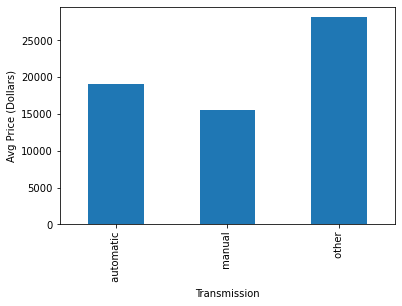

In [24]:
# visualization that shows the connection between the price and the transmission
df_trans_price = df[['Transmission','Price']].groupby("Transmission", as_index = False).mean()
plt1 = df_trans_price.plot(x = 'Transmission', kind='bar',legend = False, sort_columns = True)
plt1.set_xlabel("Transmission")
plt1.set_ylabel("Avg Price (Dollars)")

plt.show()

array([[<AxesSubplot:title={'center':'Odometer'}>,
        <AxesSubplot:title={'center':'Year'}>]], dtype=object)

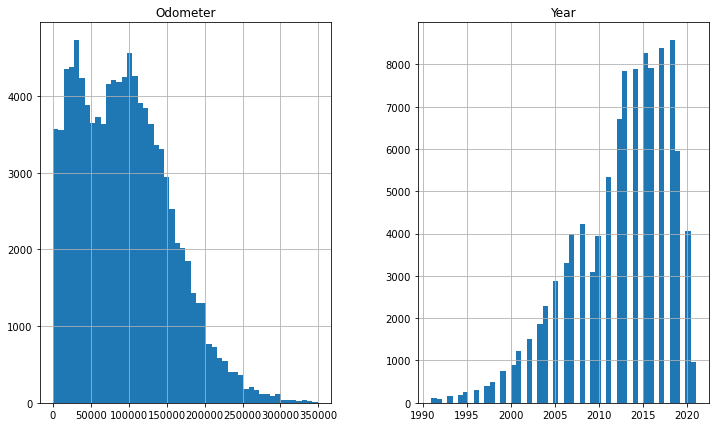

In [25]:
##########################################################################################################################
##########Visualizations###########
#let's take a look at the numeric attributes histograma:
atttibutes_hist = df[["Odometer", "Year"]].hist(bins=50, figsize=(12,7))
atttibutes_hist

<AxesSubplot:xlabel='Condition', ylabel='Price'>

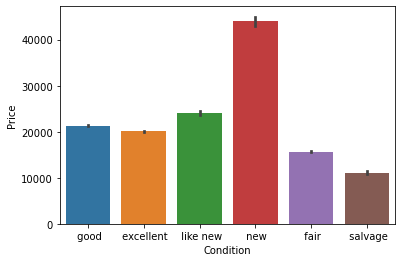

In [27]:
# visualization that shows the connection between the price and the condition
from scipy import stats
ax = sns.barplot(x="Condition", y="Price", data=df)
ax

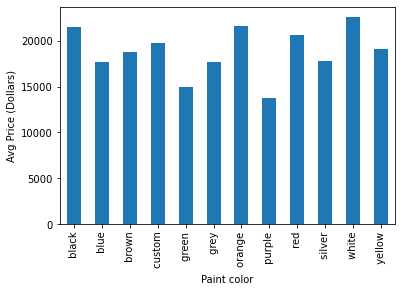

In [28]:
# visualization that shows the connection between the price and the paint color
df_trans_price = df[['Paint color','Price']].groupby("Paint color", as_index = False).mean()
plt1 = df_trans_price.plot(x = 'Paint color', kind='bar',legend = False, sort_columns = True)
plt1.set_xlabel("Paint color")
plt1.set_ylabel("Avg Price (Dollars)")

plt.show()

Text(0.5, 1.0, 'Paint color:')

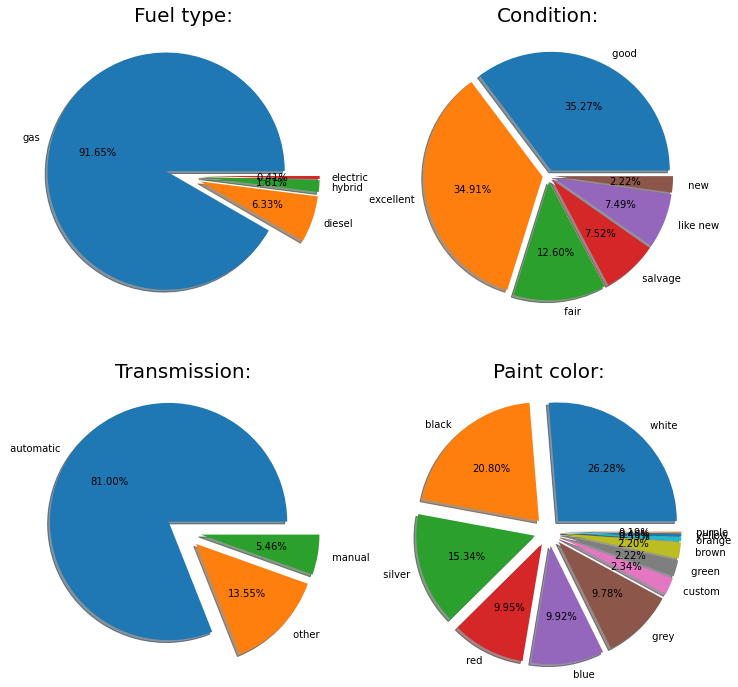

In [32]:
# visualization that shows the value counts of some features
fig, ax = plt.subplots(2,2, figsize = (12,12))
((ax1, ax2), (ax3, ax4)) = ax

labels = df['Fuel type'].value_counts().index.tolist()
values = df['Fuel type'].value_counts().tolist()
ax1.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True, explode=[0.15, 0.15, 0.15, 0.15])
ax1.set_title("Fuel type:", fontdict={'fontsize': 20})

labels = df['Condition'].value_counts().index.tolist()
values = df['Condition'].value_counts().tolist()
ax2.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True, explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05))
ax2.set_title("Condition:", fontdict={'fontsize': 20})

labels = df['Transmission'].value_counts().index.tolist()
values = df['Transmission'].value_counts().tolist()
ax3.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True, explode=(0.15, 0.15, 0.15))
ax3.set_title("Transmission:", fontdict={'fontsize': 20})

labels = df['Paint color'].value_counts().index.tolist()
values = df['Paint color'].value_counts().tolist()
ax4.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True, explode=(0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12))
ax4.set_title("Paint color:", fontdict={'fontsize': 20})

In [33]:
# here we are arranging the data before we starting the machine learing
# we are changing categorial features in to numeric features
# we are dropping the categorial features coloumns
# we are scaling the new numeric features
df3=df.copy()
trans_no = pd.get_dummies(df3['Transmission'], drop_first = True)
df3 = pd.concat([df3, trans_no], axis = 1)
Model_cat = pd.get_dummies(df3['Model'], drop_first = True)
df3 = pd.concat([df3, Model_cat], axis = 1)
Region_typ = pd.get_dummies(df3['Region'], drop_first = True)
df3 = pd.concat([df3, Region_typ], axis = 1)
fuelt = pd.get_dummies(df3['Fuel type'], drop_first = True)
df3 = pd.concat([df3, fuelt], axis = 1)
df3.replace({" new":1," like new":2," excellent": 3," good":4, " fair":5, " salvage":6}, inplace=True)
num_vars = ['Odometer', 'Price', 'Car age']
scaler = StandardScaler()
df3[num_vars] = scaler.fit_transform(df3[num_vars])

df3.drop(['Transmission', 'Model','Paint color', 'Fuel type', 'Region', 'Year'], axis = 1, inplace = True)

In [34]:
# here we are doing the machine learning proccess by using linear regression
y = df3.loc[:,['Price']]
X = df3.drop(columns=['Price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 25)

scaler_stan = StandardScaler()
scaler_stan.fit(X_train)
X_train_normalized = scaler_stan.transform(X_train)
X_test_normalized = scaler_stan.transform(X_test)

linear_reg = LinearRegression()
linear_reg.fit(X_train_normalized, y_train)
y_pred= linear_reg.predict(X_train_normalized)
print("R2 on Training set: ",linear_reg.score(X_train_normalized,y_train))
print("R2 on Testing set: ",linear_reg.score(X_test_normalized,y_test))

R2 on Training set:  0.7234094429084699
R2 on Testing set:  0.7392863458775153


In [35]:
# here we are checking the cross validation and calculating the MAE and the STD
LR = LinearRegression()
kf = KFold(n_splits=10, random_state=42, shuffle=True)
R2_scores_normalized = cross_val_score(LR, X_train_normalized, y_train, cv=kf)
y_predict_normalized = cross_val_predict(LR, X_train_normalized, y_train, cv=kf)
mae_normalized = MAE(y_train, y_predict_normalized)
print("the scores of cross validation are:")
print(R2_scores_normalized)
print()
print("mean R2 is: " + str(R2_scores_normalized.mean())[:5] + " with std of  " + str(R2_scores_normalized.std())[:5] + " and MAE of " + str(mae_normalized)[:6])

the scores of cross validation are:
[0.76884709 0.62590889 0.76243602 0.77827018 0.5059904  0.78584527
 0.77420356 0.76569714 0.78770432 0.78279003]

mean R2 is: 0.733 with std of  0.088 and MAE of 0.2974


---------------------------------
Linear Regression
Train Score:0.7234094429084699
Test Score:0.7392863458775153
---------------------------------
Figure(288x432)


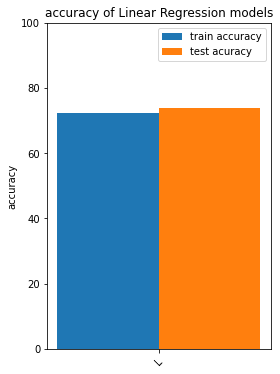

In [36]:
# visualization of the train and test scores
def Linear_Score(clf, X_train, X_test, y_test, y_train, model_name):
    print("---------------------------------")
    print(model_name)
    train_score = clf.score(X_train, y_train)
    print("Train Score:{}".format(train_score))
    test_score = clf.score(X_test, y_test)
    print("Test Score:{}".format(test_score))
    print("---------------------------------")
    return train_score, test_score
    

def Linear_Regression(X_train, y_train):
    clf = LinearRegression().fit(X_train, y_train)
    return clf

def Model_plots (labels, train_accuracy,test_acuracy,column_name):
    x = np.arange(1)  # the label locations
    width = 0.15  # the width of the bars
    fig, ax = plt.subplots(figsize=(4,6))
    rects1 = ax.bar(x - width/2, train_accuracy, width, label='train accuracy')
    rects2 = ax.bar(x + width/2, test_acuracy, width, label='test acuracy')
    ax.set_ylabel('accuracy')
    ax.set_title('accuracy of {} models'.format(column_name))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.ylim([0,100])
    plt.xticks(rotation='45')
    ax.legend()
    print(fig)

Linear_Regression_clf = Linear_Regression(X_train_normalized, y_train)
Linear_Regression_Score = Linear_Score(Linear_Regression_clf, X_train_normalized, X_test_normalized, y_test, y_train, "Linear Regression")
labels = 'L'
train_accuracy = Linear_Regression_Score[0]*100
test_acuracy = Linear_Regression_Score[1]*100
column_name='Linear Regression'
Model_plots (labels, train_accuracy,test_acuracy,column_name)

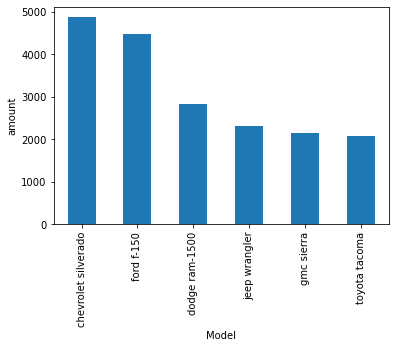

In [37]:
# visualization that shows the 6 most models in the dataset
df_most_models = df['Model'].value_counts().head(n=6)

plt1 = df_most_models.plot(x = 'Model', kind='bar',legend = False, sort_columns = True)
plt1.set_xlabel("Model")
plt1.set_ylabel("amount")

plt.show()

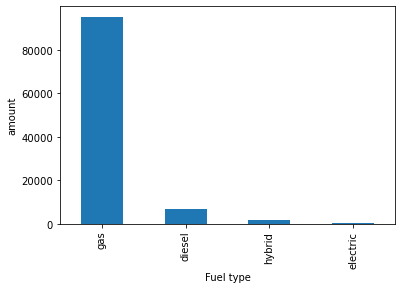

In [38]:
# visualization that shows the amount of the different fuel types
df_fuel = df['Fuel type'].value_counts()

plt1 = df_fuel.plot(x = 'Fuel type', kind='bar',legend = False, sort_columns = True)
plt1.set_xlabel("Fuel type")
plt1.set_ylabel("amount")

plt.show()

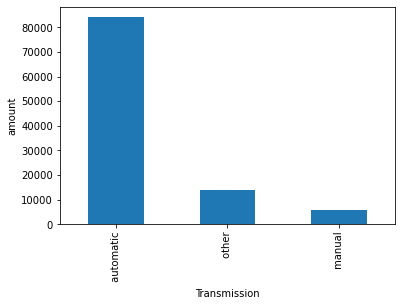

In [39]:
# visualization that shows the amount of the different transmission
df_trans = df['Transmission'].value_counts()

plt1 = df_trans.plot(x = 'Transmission', kind='bar',legend = False, sort_columns = True)
plt1.set_xlabel("Transmission")
plt1.set_ylabel("amount")

plt.show()